In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pyod

     |████████████████████████████████| 113 kB 5.1 MB/s 
  Created wheel for pyod: filename=pyod-0.9.5-py3-none-any.whl size=132699 sha256=c83f2d896597d95c606a90e9dd7562036517e8e5fd1c15b7860d17c97a5e3709
  Stored in directory: /root/.cache/pip/wheels/3d/bb/b7/62b60fb451b33b0df1ab8006697fba7a6a49709a629055cf77
Successfully built pyod


In [ ]:
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42025 sha256=3779d6db26e1dac19aee333d81f601f59dc6f35d2a7e5cfcf3b31541947e0cdc
  Stored in directory: /root/.cache/pip/wheels/cf/2e/45/d4cb985fb061e3ab636d350b76114d2639d84eab16225c7776
Successfully built combo


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyod.models.pca import PCA
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#### **Principal component analysis (PCA)** can be used in detecting outliers. PCA is a linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.


#### In this procedure, **covariance matrix** of the data can be decomposed to orthogonal vectors, called **eigenvectors**, associated with **eigenvalues**. The eigenvectors with high eigenvalues capture most of the variance in the data.

#### Therefore, a low dimensional hyperplane constructed by k eigenvectors can capture most of the variance in the data. However, outliers are different from normal data points, which is more obvious on the hyperplane constructed by the eigenvectors with small eigenvalues.


#### Therefore, outlier scores can be obtained as the sum of the projected distance of a sample on all eigenvectors


#### **Score(X)** = Sum of weighted euclidean distance between each sample to the hyperplane constructed by the selected eigenvectors

### Parameters

**n_components** (int, float, None or string) – Number of components to keep. if n_components is not set all components are kept:

**contamination** (float in (0., 0.5), optional (default=0.1)) – The amount of contamination of the data set.

**standardization** (bool, optional (default=True)) – If True, perform standardization first to convert data to zero mean and unit variance

**decision_scores_** : The outlier scores of the training data. The higher, the more abnormal. Outliers tend to have higher scores. This value is available once the detector is fitted.

**labels_** :
The binary labels of the training data. 0 stands for inliers and 1 for outliers/anomalies.

**decision_function(X)**:
Predict raw anomaly score of X using the fitted detector.

In [ ]:
df = pd.read_excel('/content/gdrive/My Drive/Udemy courses/Proper for recording/Store.xls')
cols = ['Sales', 'Profit']
##Scaling Sales and Profit to between zero and one.
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [ ]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

OUTLIERS: 100 INLIERS: 9894


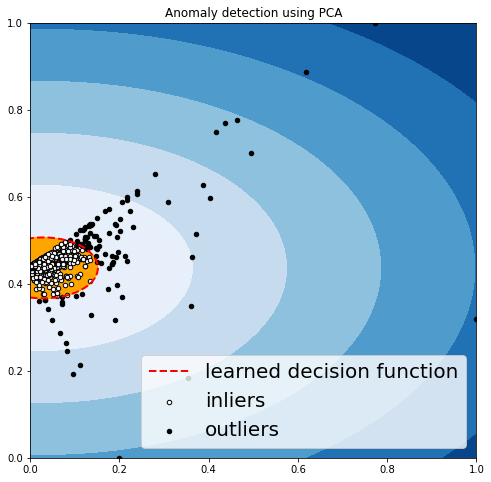

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = PCA(contamination=0.01)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Anomaly detection using PCA')
plt.show();